# S&P 500 Trading Algorithm

This notebook implements a trading algorithm for the S&P 500 using machine learning models. We will use available parameters as signals and build models like FFNN, LSTM, and CNN.

## Data Loading and Exploration

In [35]:
import pandas as pd
import numpy as np


# Load the CSV data
data = pd.read_csv("C:/Users/David/Documents/GitHub/Quantitative_Trading_Algorithm/output.csv")

# Print the columns to understand the data structure
print("Data Columns:")
print(data.columns)

# Based on the legend, we should map these columns to lowercase
selected_columns = [
    'emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr',
    'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un',
    'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf',
    '_au', '_dxy', '_lcp', '_ty', '_oil',
    '_mkt', '_va', '_gr'
]

# Check if the selected columns are in the data
available_columns = [col for col in selected_columns if col in data.columns]
print("Selected Available Columns:")
print(available_columns)

# Extracting the relevant columns
data = data[available_columns + ['snp']]  # Including 'snp' as target

Data Columns:
Index(['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10',
       'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss',
       'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr',
       'snp', 'date', 'year', 'month', 'day', 'label'],
      dtype='object')
Selected Available Columns:
['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr']


## Preprocess and Feature Engineering

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Handle missing values
data = data.dropna()

# Extract features and target
features = data.drop(columns=['snp'])
target = data['snp']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

print("Feature Engineering and Data Preprocessing Complete.")


Feature Engineering and Data Preprocessing Complete.


## Custom Train-Test Split for LSTM To Keep Data Sequential

In [37]:
# Custom function to split data for each year to keep the data sequential
def custom_train_test_split(features, target, train_size=42, test_size=10):
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
    for start in range(0, len(features), train_size + test_size):
        end_train = start + train_size
        end_test = end_train + test_size
        if end_test <= len(features):
            X_train_list.append(features[start:end_train])
            y_train_list.append(target[start:end_train])
            X_test_list.append(features[end_train:end_test])
            y_test_list.append(target[end_train:end_test])
    
    X_train_lstm_prepared = np.concatenate(X_train_list)
    y_train_lstm_prepared = np.concatenate(y_train_list)
    X_test_lstm_prepared = np.concatenate(X_test_list)
    y_test_lstm_prepared = np.concatenate(y_test_list)
    
    return X_train_lstm_prepared, y_train_lstm_prepared, X_test_lstm_prepared, y_test_lstm_prepared

# Split the data using the custom function
X_train_lstm_prepared, y_train_lstm_prepared, X_test_lstm_prepared, y_test_lstm_prepared = custom_train_test_split(features_scaled, target)

# Reshape data for LSTM (needs 3D input)
X_train_lstm = X_train_lstm_prepared.reshape((X_train_lstm_prepared.shape[0], 1, X_train_lstm_prepared.shape[1]))
X_test_lstm = X_test_lstm_prepared.reshape((X_test_lstm_prepared.shape[0], 1, X_test_lstm_prepared.shape[1]))


## Model Implementation

### Feed-Forward Neural Network (FFNN)

Epoch 1/50


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3696391.0000 - val_loss: 3819688.7500
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3522058.5000 - val_loss: 3481374.2500
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3232221.0000 - val_loss: 2541246.5000
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2021917.8750 - val_loss: 1217791.2500
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1071318.7500 - val_loss: 372480.8438
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 396475.2188 - val_loss: 164795.9531
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 226443.5156 - val_loss: 117387.8516
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 202239.2969 - val_loss: 93257.6875
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 193601.8281 - val_loss: 75332.2422
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171258.3750 - val_loss: 61703.6562
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14239

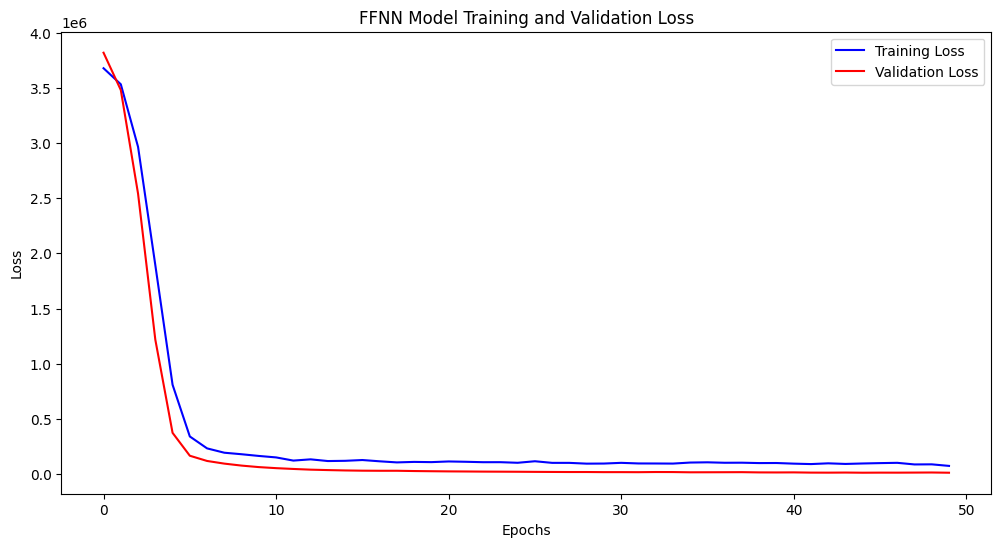

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the FFNN model creation function
def create_ffnn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Training with all parameters
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

ffnn_model = create_ffnn_model(X_train_scaled.shape[1])
ffnn_history = ffnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

ffnn_evaluation = ffnn_model.evaluate(X_test_scaled, y_test)
print(f"FFNN Model Test Loss: {ffnn_evaluation}")

ffnn_predictions = ffnn_model.predict(X_test_scaled)
print("FFNN Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(ffnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(ffnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('FFNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Long Short-Term Memory Network (LSTM)

Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1386855.8750 - val_loss: 12303477.0000
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1387333.7500 - val_loss: 12300020.0000
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1424984.3750 - val_loss: 12293217.0000
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1430969.0000 - val_loss: 12281729.0000
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1378564.3750 - val_loss: 12257948.0000
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1361539.1250 - val_loss: 12215362.0000
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1414627.5000 - val_loss: 12140253.0000
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1355804.1250 - val_loss: 12031072.0000
Epoch 9/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1366537.0000 - val_loss: 11857700.0000
Epoch 10/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1345750.6250 - val_loss: 11572433.0000
Epoch 11/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

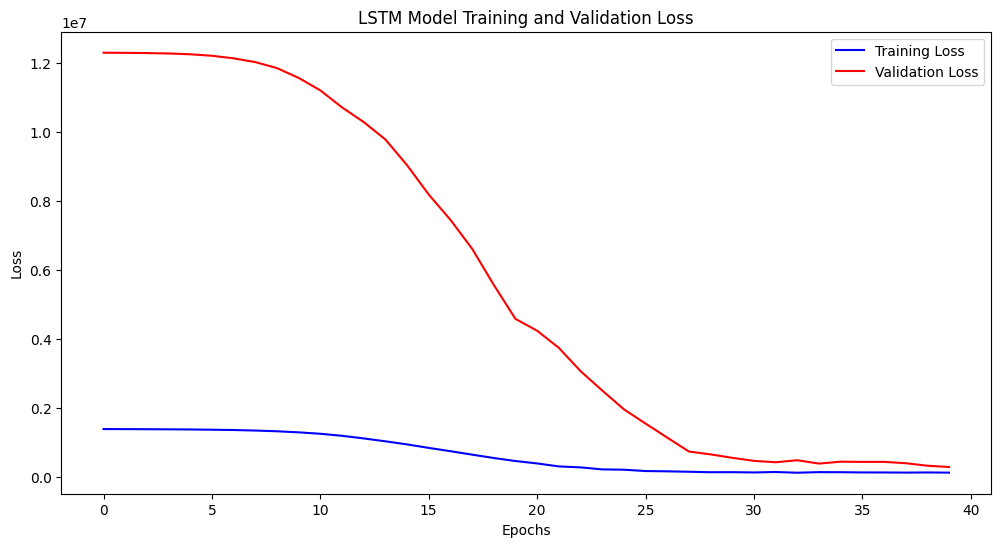

In [39]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(10, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))  # Add dropout for regularization
    model.add(BatchNormalization())  # Add batch normalization
    model.add(Dense(32, activation='relu'))  # Add an additional dense layer
    model.add(Dropout(0.5))  # Add another dropout for regularization
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train_lstm, y_train_lstm_prepared, epochs=40, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

lstm_evaluation = lstm_model.evaluate(X_test_lstm, y_test_lstm_prepared)
print(f"LSTM Model Test Loss: {lstm_evaluation}")

lstm_predictions = lstm_model.predict(X_test_lstm)
print("LSTM Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Convolutional Neural Network (CNN)

Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3371891.2500 - val_loss: 1146724.0000
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1114127.5000 - val_loss: 870616.8125
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 827326.0000 - val_loss: 420336.0938
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 346507.4375 - val_loss: 139216.7344
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 145751.5781 - val_loss: 93314.8516
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 101281.5312 - val_loss: 65836.4609
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66420.0781 - val_loss: 50375.9727
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51587.5938 - val_loss: 40783.7695
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44474.1406 - val_loss: 34885.7852
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39226.7383 - val_loss: 27989.8379
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35396.9219 - val_l

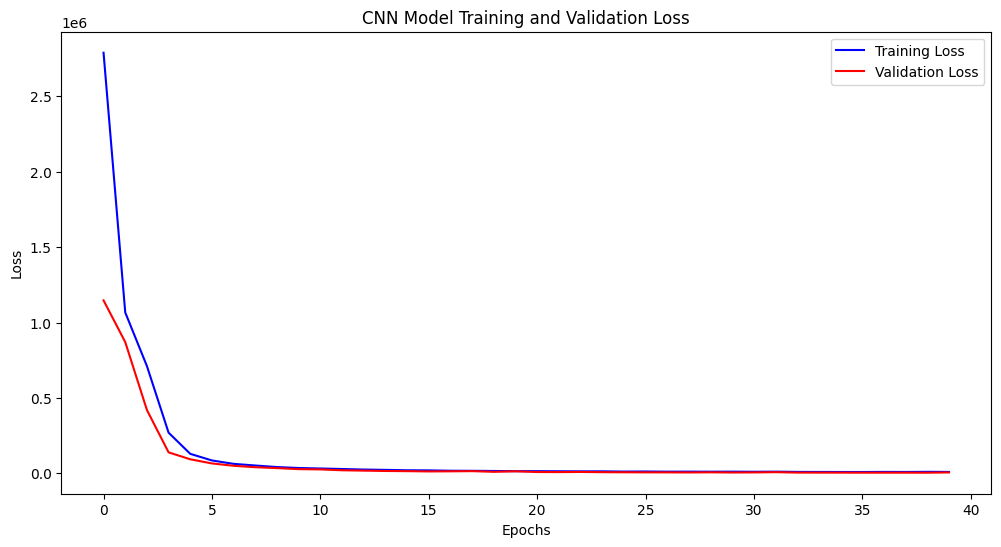

In [40]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Define the CNN model creation function
def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Reshape((input_dim, 1), input_shape=(input_dim,)))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))  # Dropout layer to reduce overfitting
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model = create_cnn_model(X_train_scaled.shape[1])
cnn_history = cnn_model.fit(X_train_scaled, y_train, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation = cnn_model.evaluate(X_test_scaled, y_test)
print(f"CNN Model Test Loss: {cnn_evaluation}")

cnn_predictions = cnn_model.predict(X_test_scaled)
print("CNN Model Training and Evaluation Complete.")

plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('CNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#
From here trash code

Dave Evaluation of Strategy:
- [ ] Sharpe Ratio -> Verschoben auf nach Strategie Implementation
- [x] In sample, out sample performance
- [x] Information Coefficient


Rafael
- [ ] Use Multiple Sets of Signals

Felix
- [ ] Write shit
- [ ] Hyperparameter Tuning (Optional)

After:
- [ ] Hyperparameter Tuning
- [ ] Data Augmentation


## Backtest and Evaluate the Models

Get the in-sample and out-of-sample R-Squared and MSE


In [41]:
from sklearn.metrics import mean_squared_error, r2_score

# In sample predictions, i.e. predict on the train dataset
ffnn_train_predictions = ffnn_model.predict(X_train)
lstm_train_predictions = lstm_model.predict(X_train_lstm)
cnn_train_predictions = cnn_model.predict(X_train)

# FFNN performance
ffnn_in_sample_r2 = r2_score(y_train, ffnn_train_predictions)
ffnn_out_sample_r2 = r2_score(y_test, ffnn_predictions)
ffnn_in_sample_mse = mean_squared_error(y_train, ffnn_train_predictions)
ffnn_out_sample_mse = mean_squared_error(y_test, ffnn_predictions)

# LSTM performance
lstm_in_sample_r2 = r2_score(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_r2 = r2_score(y_test_lstm_prepared, lstm_predictions)
lstm_in_sample_mse = mean_squared_error(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_mse = mean_squared_error(y_test_lstm_prepared, lstm_predictions)

# CNN performance
cnn_in_sample_r2 = r2_score(y_train, cnn_train_predictions)
cnn_out_sample_r2 = r2_score(y_test, cnn_predictions)
cnn_in_sample_mse = mean_squared_error(y_train, cnn_train_predictions)
cnn_out_sample_mse = mean_squared_error(y_test, cnn_predictions)

print(f"FFNN In-sample R-squared: {ffnn_in_sample_r2}")
print(f"FFNN In-sample MSE: {ffnn_in_sample_mse}")
print(f"FFNN Out-sample R-squared: {ffnn_out_sample_r2}")
print(f"FFNN Out-sample MSE: {ffnn_out_sample_mse}")
print("---------------------------------------------------")
print(f"LSTM In-sample R-squared: {lstm_in_sample_r2}")
print(f"LSTM In-sample MSE: {lstm_in_sample_mse}")
print(f"LSTM Out-sample R-squared: {lstm_out_sample_r2}")
print(f"LSTM Out-sample MSE: {lstm_out_sample_mse}")
print("---------------------------------------------------")
print(f"CNN In-sample R-squared: {cnn_in_sample_r2}")
print(f"CNN In-sample MSE: {cnn_in_sample_mse}")
print(f"CNN Out-sample R-squared: {cnn_out_sample_r2}")
print(f"CNN Out-sample MSE: {cnn_out_sample_mse}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FFNN In-sample R-squared: 0.9900242415127356
FFNN In-sample MSE: 12959.579057506495
FFNN Out-sample R-squared: 0.9894831981786991
FFNN Out-sample MSE: 15586.73633909689
---------------------------------------------------
LSTM In-sample R-squared: 0.9359495555409576
LSTM In-sample MSE: 78571.09022879318
LSTM Out-sample R-squared: 0.9384141484621864
LSTM Out-sample MSE: 88280.31153545357
---------------------------------------------------
CNN In-sample R-squared: -3.673059099228185
CNN In-sample MSE: 6070804.431980128
CNN Out-sample R-squared: 0.9952324385700295
CNN Out-sample MSE: 7065.90503958038


The Information Coefficient (IC) measures the correlation between predicted and actual returns.
see: https://www.investopedia.com/terms/i/information-coefficient.asp

In [42]:
import numpy as np

def calculate_proportion_correct(predictions, actuals):
    # Flatten the arrays to 1D
    predictions = predictions.flatten()
    actuals = actuals.flatten()
    
    # Align the lengths by trimming the last element of both arrays if one is longer than the other
    min_length = min(len(predictions), len(actuals))
    predictions = predictions[:min_length]
    actuals = actuals[:min_length]
    
    # Calculate the direction of actual returns and predicted returns
    actual_directions = np.diff(actuals) > 0
    predicted_directions = np.diff(predictions) > 0
    
    # Determine the correct predictions (correct direction)
    correct_predictions = np.where(predicted_directions == actual_directions, 1, 0)
    
    # Calculate the proportion of correct predictions
    proportion_correct = np.mean(correct_predictions)
    
    return proportion_correct

def calculate_ic(proportion_correct):
    return (2 * proportion_correct) - 1

# Calculate proportion correct for FFNN
ffnn_proportion_correct = calculate_proportion_correct(ffnn_predictions, y_test.values)
ffnn_ic_new = calculate_ic(ffnn_proportion_correct)

print(f"FFNN Information Coefficient: {ffnn_ic_new}")
print("---------------------------------------------------")
# Calculate proportion correct for LSTM
lstm_proportion_correct = calculate_proportion_correct(lstm_predictions, y_test_lstm_prepared)
lstm_ic_new = calculate_ic(lstm_proportion_correct)
print(f"LSTM Information Coefficient: {lstm_ic_new}")
print("---------------------------------------------------")
cnn_proportion_correct = calculate_proportion_correct(cnn_predictions, y_test.values)
cnn_ic_new = calculate_ic(cnn_proportion_correct)
print(f"CNN Information Coefficient: {cnn_ic_new}")


FFNN Information Coefficient: 0.8989361702127661
---------------------------------------------------
LSTM Information Coefficient: 0.15877437325905297
---------------------------------------------------
CNN Information Coefficient: 0.925531914893617


Sharpe Ratio Calculation:
Still To Do


### Show and Discuss Results
We will create charts to visualize the actual vs. predicted values for each model and discuss the results.

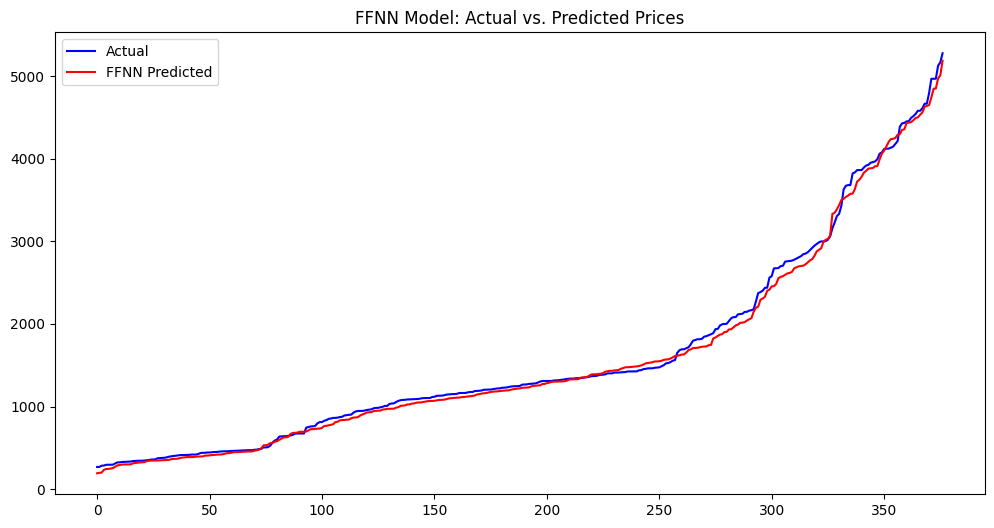

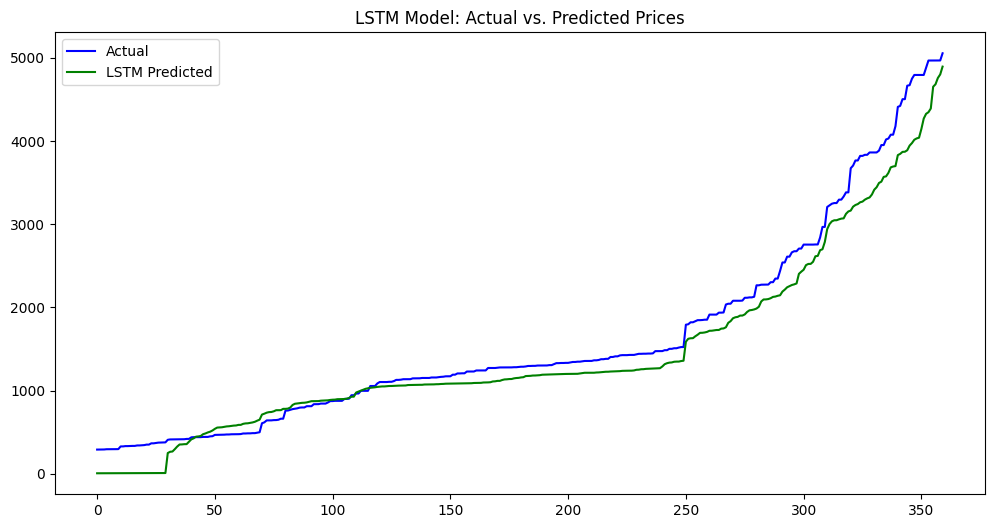

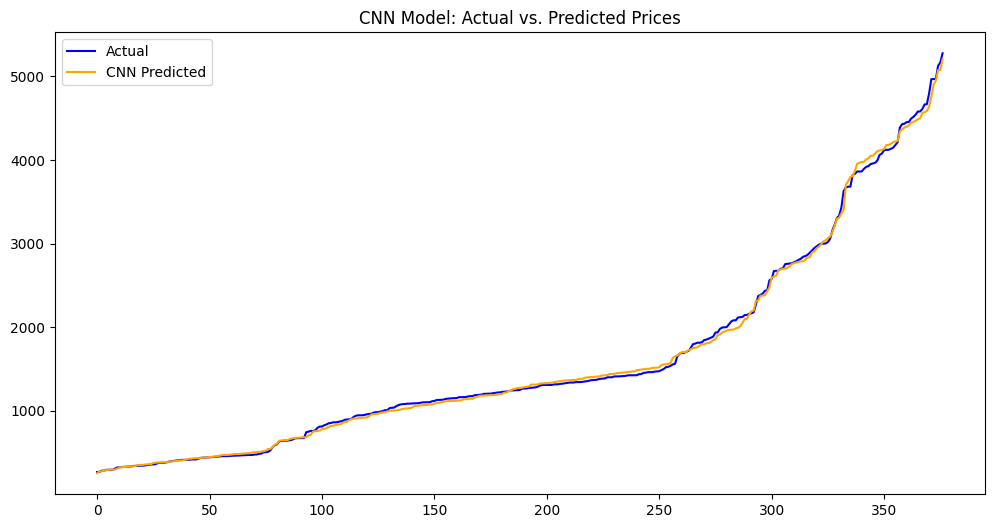

In [43]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted values for FFNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(ffnn_predictions.flatten()), label='FFNN Predicted', color='red')
plt.title('FFNN Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Plot actual vs. predicted values for LSTM
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test_lstm_prepared), label='Actual', color='blue')
plt.plot(sorted(lstm_predictions.flatten()), label='LSTM Predicted', color='green')
plt.title('LSTM Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Plot actual vs. predicted values for CNN
plt.figure(figsize=(12, 6))
plt.plot(sorted(y_test.values), label='Actual', color='blue')
plt.plot(sorted(cnn_predictions.flatten()), label='CNN Predicted', color='orange')
plt.title('CNN Model: Actual vs. Predicted Prices')
plt.legend()
plt.show()


# DAVE TILL HERE

# RAFAEL FROM HERE

### Step 3: Use Multiple Sets of Signals
We will evaluate the models using two sets of signals:

Set 1: Macroeconomic Signals:

GDP: Gross Domestic Product growth.
CPI: Inflation rate.
UN: Unemployment rate.
IR: Nominal interest rate.
Y10: 10Y treasury yield.
Economic Motivation: These indicators are fundamental to the overall economic environment and can significantly influence stock market movements. Changes in GDP, inflation, and interest rates are closely monitored by investors.

Set 2: Market and Technical Signals:

PE: Price/Earnings ratio.
DY: Dividend yield.
_MKT: Market returns.
_VA: Value index.
_GR: Growth index.
Economic Motivation: These indicators provide insight into market valuation and performance. They help understand the relative attractiveness of stocks and the broader market trends.

We will re-train and evaluate the models using these sets of signals.

## FFNN

In [44]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)

ffnn_model_macro = create_ffnn_model(X_train_macro.shape[1])
ffnn_history_macro = ffnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_macro = ffnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"FFNN Model with Macro Signals Test Loss: {ffnn_evaluation_macro}")

ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

ffnn_model_market = create_ffnn_model(X_train_market.shape[1])
ffnn_history_market = ffnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1)

ffnn_evaluation_market = ffnn_model_market.evaluate(X_test_market, y_test_market)
print(f"FFNN Model with Market Signals Test Loss: {ffnn_evaluation_market}")

ffnn_market_predictions = ffnn_model_market.predict(X_test_market)



Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3500806.2500 - val_loss: 3817160.7500
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3429112.2500 - val_loss: 3744592.7500
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3291022.2500 - val_loss: 3519872.7500
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3216789.2500 - val_loss: 3078714.0000
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2915315.5000 - val_loss: 2516228.2500
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2072174.1250 - val_loss: 2028968.7500
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1852316.6250 - val_loss: 1750999.3750
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1837375.6250 - val_loss: 1624440.7500
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1700972.7500 - val_loss: 1551848.5000
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1660456.8750 - val_loss: 1498736.7500
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3794102.5000 - val_loss: 3814006.7500
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3587303.7500 - val_loss: 3733028.5000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3559969.7500 - val_loss: 3508236.0000
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3293300.5000 - val_loss: 3064195.0000
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2921689.7500 - val_loss: 2420663.5000
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2145358.7500 - val_loss: 1706468.5000
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1574450.5000 - val_loss: 1089118.0000
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 940355.3750 - val_loss: 701260.0000
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 757280.2500 - val_loss: 494062.9062
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 577384.5625 - val_loss: 404473.0000
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

# LSTM

In [45]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter and reshape data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

# Split the data using the custom function
X_train_macro_prepared, y_train_macro_prepared, X_test_macro_prepared, y_test_macro_prepared = custom_train_test_split(features_macro_scaled, target_macro)

# Reshape data for LSTM (needs 3D input)
X_train_macro_lstm = X_train_macro_prepared.reshape((X_train_macro_prepared.shape[0], 1, X_train_macro_prepared.shape[1]))
X_test_macro_lstm = X_test_macro_prepared.reshape((X_test_macro_prepared.shape[0], 1, X_test_macro_prepared.shape[1]))

lstm_model_macro = create_lstm_model((X_train_macro_lstm.shape[1], X_train_macro_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience
lstm_history_macro = lstm_model_macro.fit(X_train_macro_lstm, y_train_macro_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_macro = lstm_model_macro.evaluate(X_test_macro_lstm, y_test_macro_prepared)
print(f"LSTM Model with Macro Signals Test Loss: {lstm_evaluation_macro}")

lstm_macro_predictions = lstm_model_macro.predict(X_test_macro_lstm)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter and reshape data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

# Split the data using the custom function
X_train_market_prepared, y_train_market_prepared, X_test_market_prepared, y_test_market_prepared = custom_train_test_split(features_market_scaled, target_market)

# Reshape data for LSTM (needs 3D input)
X_train_market_lstm = X_train_market_prepared.reshape((X_train_market_prepared.shape[0], 1, X_train_market_prepared.shape[1]))
X_test_market_lstm = X_test_market_prepared.reshape((X_test_market_prepared.shape[0], 1, X_test_market_prepared.shape[1]))

lstm_model_market = create_lstm_model((X_train_market_lstm.shape[1], X_train_market_lstm.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Increased patience
lstm_history_market = lstm_model_market.fit(X_train_market_lstm, y_train_market_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_market = lstm_model_market.evaluate(X_test_market_lstm, y_test_market_prepared)
print(f"LSTM Model with Market Signals Test Loss: {lstm_evaluation_market}")

lstm_market_predictions = lstm_model_market.predict(X_test_market_lstm)
lstm_market_mse = mean_squared_error(y_test_market_prepared, lstm_market_predictions)
lstm_market_r2 = r2_score(y_test_market_prepared, lstm_market_predictions)


Epoch 1/100


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1397584.6250 - val_loss: 12303394.0000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1414729.0000 - val_loss: 12300048.0000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1366938.1250 - val_loss: 12293190.0000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1423500.8750 - val_loss: 12279973.0000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1403011.5000 - val_loss: 12256255.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1366721.1250 - val_loss: 12217916.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1368250.8750 - val_loss: 12158461.0000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1340001.5000 - val_loss: 12072349.0000
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1356928.2500 - val_loss: 11953705.0000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1264758.2500 - val_loss: 11792373.0000
Epoch 11/100
38/38 ━━━━━━━━━━━━

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1345115.8750 - val_loss: 12302186.0000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1378995.5000 - val_loss: 12297288.0000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1366107.3750 - val_loss: 12287413.0000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1392467.1250 - val_loss: 12267666.0000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1430859.8750 - val_loss: 12230741.0000
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1392106.3750 - val_loss: 12154033.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1388747.7500 - val_loss: 12008080.0000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1313514.1250 - val_loss: 11753651.0000
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1300023.1250 - val_loss: 11316081.0000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1248361.6250 - val_loss: 10708245.0000
Epoch 11/100
38/38 ━━━━━━━━━━━━

# CNN

In [46]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_macro = create_cnn_model(X_train_macro.shape[1])
cnn_history_macro = cnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation_macro = cnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"CNN Model with Macro Signals Test Loss: {cnn_evaluation_macro}")

cnn_macro_predictions = cnn_model_macro.predict(X_test_macro)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_market = create_cnn_model(X_train_market.shape[1])
cnn_history_market = cnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation_market = cnn_model_market.evaluate(X_test_market, y_test_market)
print(f"CNN Model with Market Signals Test Loss: {cnn_evaluation_market}")

cnn_market_predictions = cnn_model_market.predict(X_test_market)


Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3584889.0000 - val_loss: 3350181.0000
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2382321.2500 - val_loss: 1412852.2500
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1493213.0000 - val_loss: 1355201.3750
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1388566.3750 - val_loss: 1330270.8750
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1342237.6250 - val_loss: 1249801.8750
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1418406.7500 - val_loss: 1224404.6250
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1263335.3750 - val_loss: 1203787.1250
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1245081.5000 - val_loss: 1170390.2500
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1439993.5000 - val_loss: 1162114.3750
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1200350.3750 - val_loss: 1118239.2500
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3642959.0000 - val_loss: 3326299.7500
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2221239.0000 - val_loss: 616420.3125
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 648244.4375 - val_loss: 411540.6250
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 419743.6875 - val_loss: 220778.7344
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 226606.8750 - val_loss: 85525.2656
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 77178.4375 - val_loss: 32834.5391
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38275.3555 - val_loss: 23868.7461
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31263.0254 - val_loss: 20577.6641
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27261.8203 - val_loss: 17439.7324
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23805.5156 - val_loss: 15352.7266
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24024.1621 - val_lo

# DAVE AB HIER WIEDER

### Step 4: In-sample and Out-of-sample Performance
In-sample Predictions and Plotting:

Evaluate the in-sample performance using training data.
Compare the in-sample predictions to the actual values.
Plot the actual vs. predicted values for in-sample data.

Out-of-sample Predictions and Plotting:

Evaluate the out-of-sample performance using testing data (already calculated).
Compare the out-of-sample predictions to the actual values.
Plot the actual vs. predicted values for out-of-sample data.

### Step 5: Analyze Hypotheses and Results
We will form hypotheses based on our two sets of signals and compare the results to these expectations.

Hypotheses:

Macroeconomic Signals:

Hypothesis: Macroeconomic indicators such as GDP, CPI, and interest rates significantly influence the S&P 500 movements, and models using these signals will have strong predictive power.
Expected Results: Higher R-squared values and lower MSE for models trained with macroeconomic signals compared to other signals.
Market and Technical Signals:

Hypothesis: Market and technical indicators, such as P/E ratio, dividend yield, and market returns, provide a closer insight into stock market valuation and performance. These signals should lead to better short-term predictive performance.
Expected Results: More accurate short-term predictions reflected in tighter alignment of actual vs. predicted values.
Evaluate and Discuss Results:

Compare the in-sample and out-of-sample performance of models using different sets of signals.
Discuss whether the results support the initial hypotheses.

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Model,In-sample MSE,Out-sample MSE,In-sample R2,Out-sample R2,In-sample IC,Out-sample IC
0,FFNN Macro,6.209460e+05,7.759284e+05,0.521915,0.454239,0.559605,0.531915
1,FFNN Market,9.652957e+03,1.210444e+04,0.992568,0.991486,0.931663,0.911348
2,LSTM Macro,1.192134e+06,1.473065e+06,0.028183,-0.027635,0.016545,0.064067
3,LSTM Market,2.645091e+04,2.599961e+04,0.978437,0.981862,0.065520,0.181058
4,CNN Macro,2.604841e+05,3.029320e+05,0.799446,0.786928,0.690205,0.624113
5,CNN Market,5.150329e+03,6.524959e+03,0.996035,0.995411,0.945330,0.943262


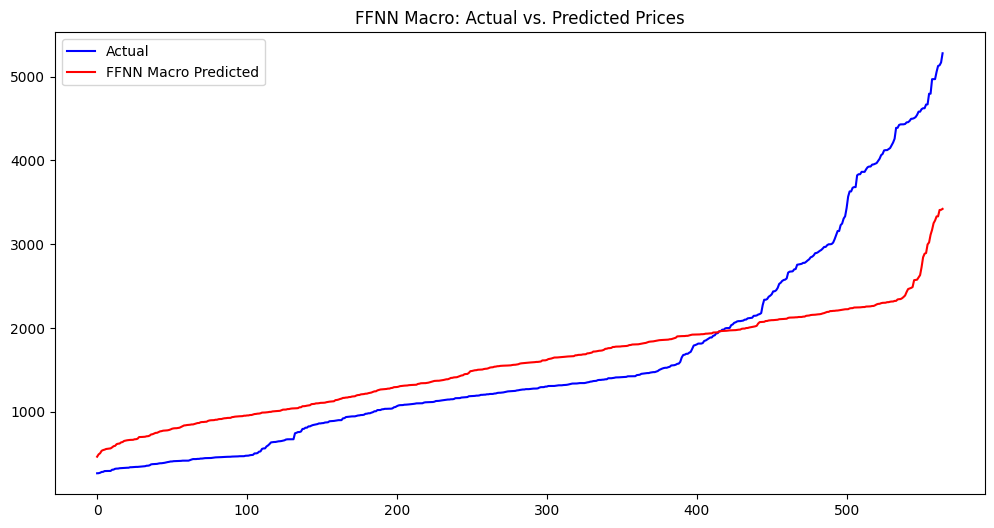

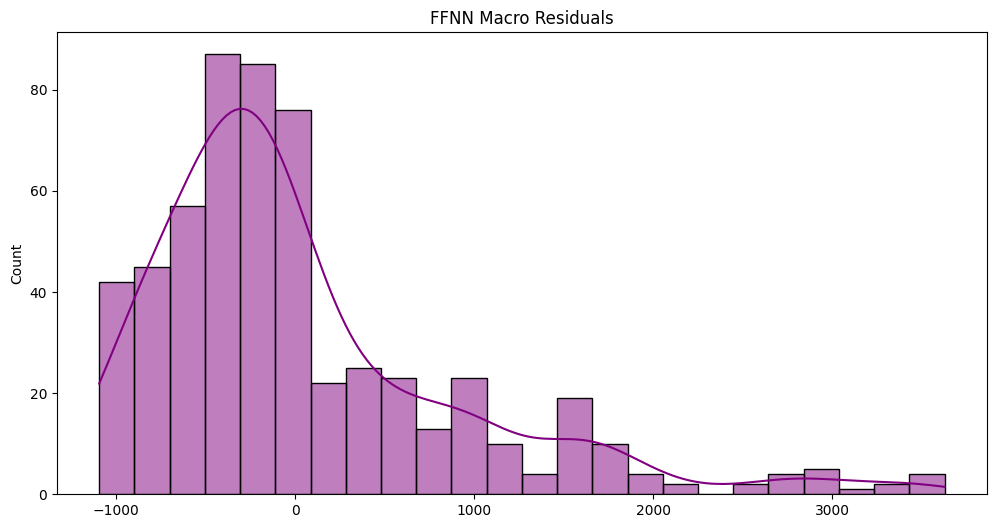

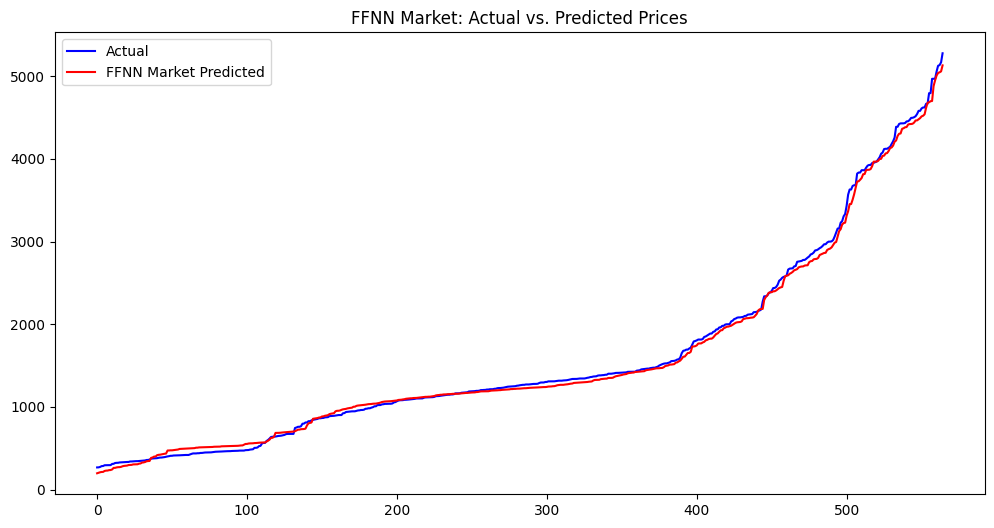

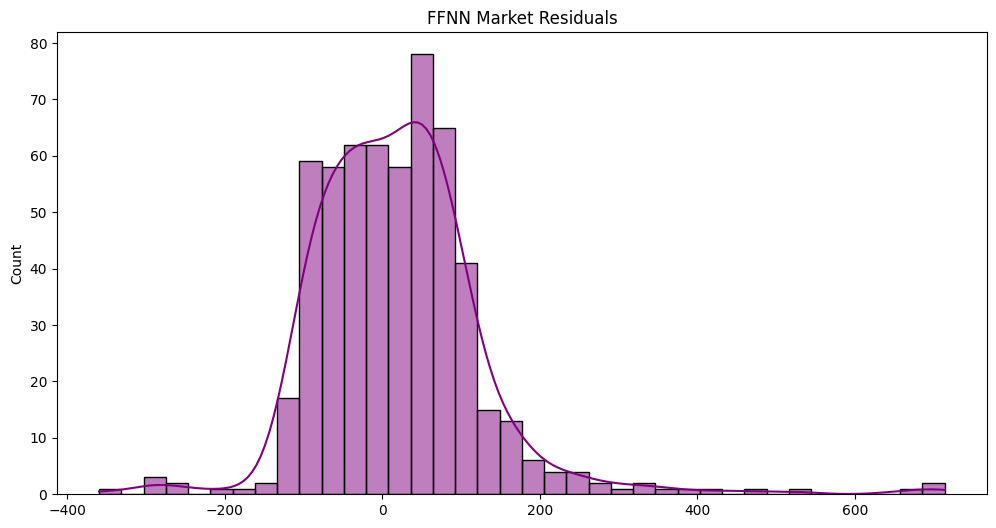

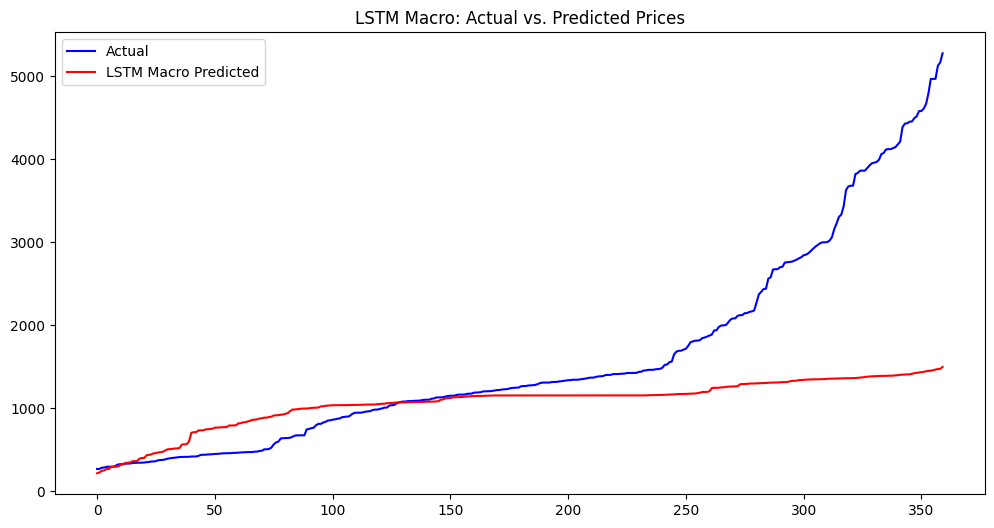

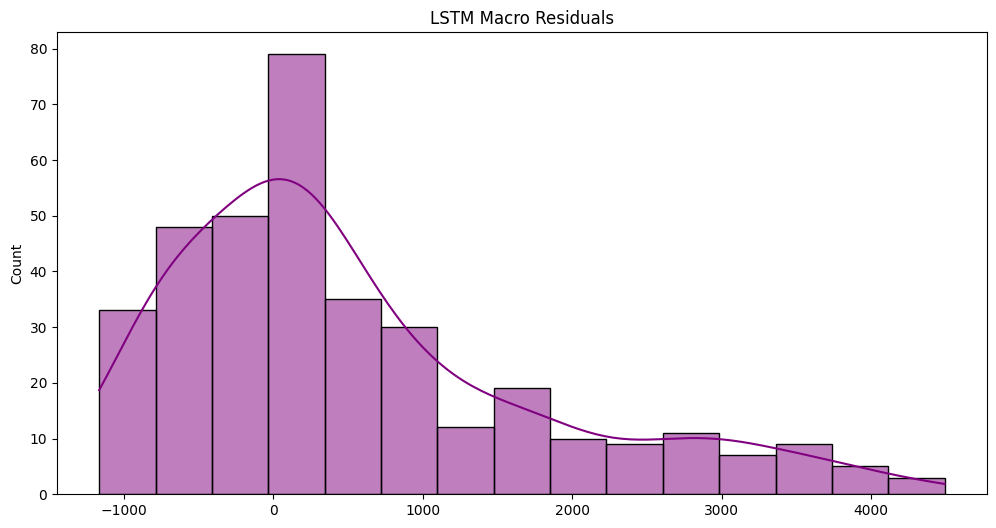

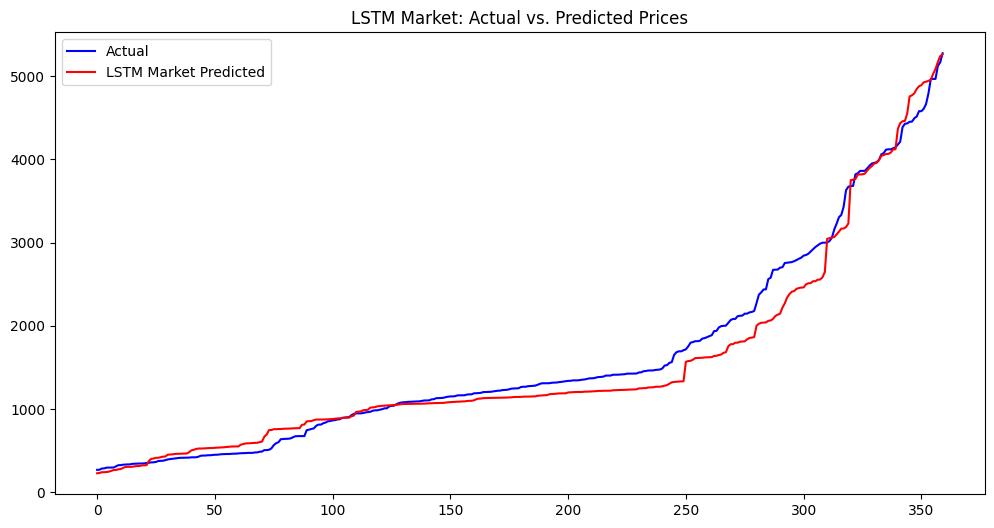

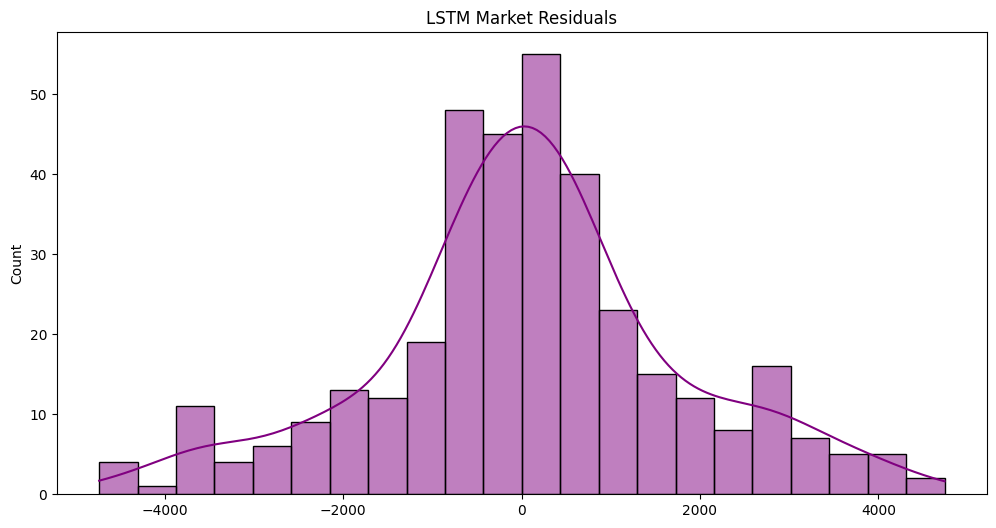

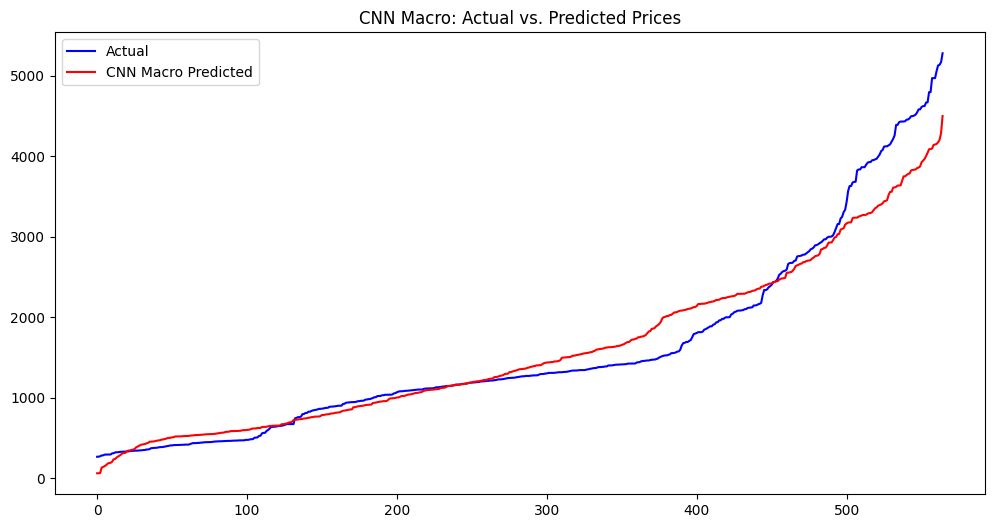

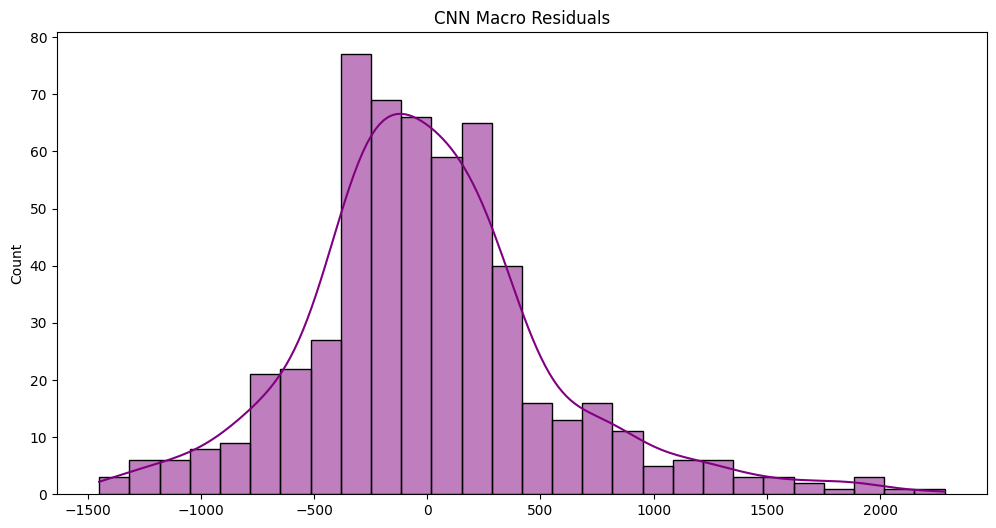

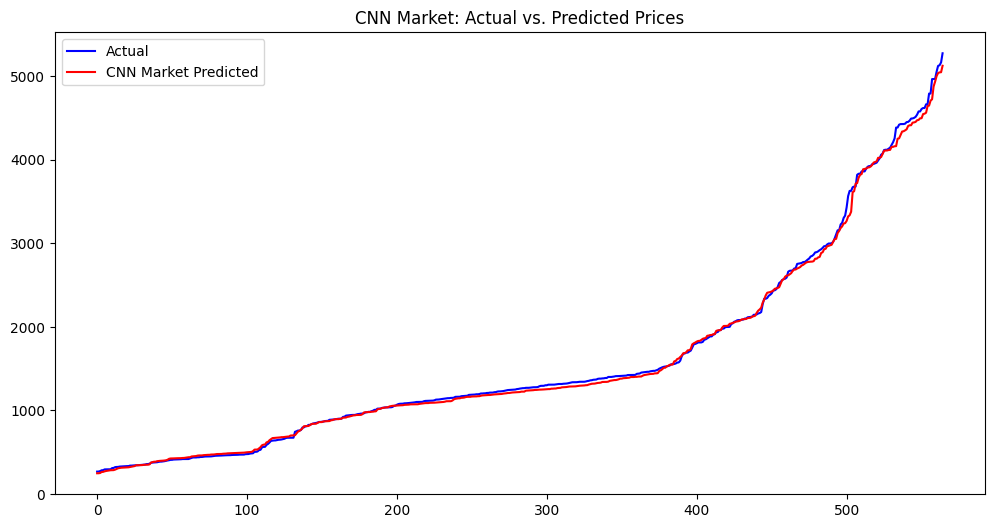

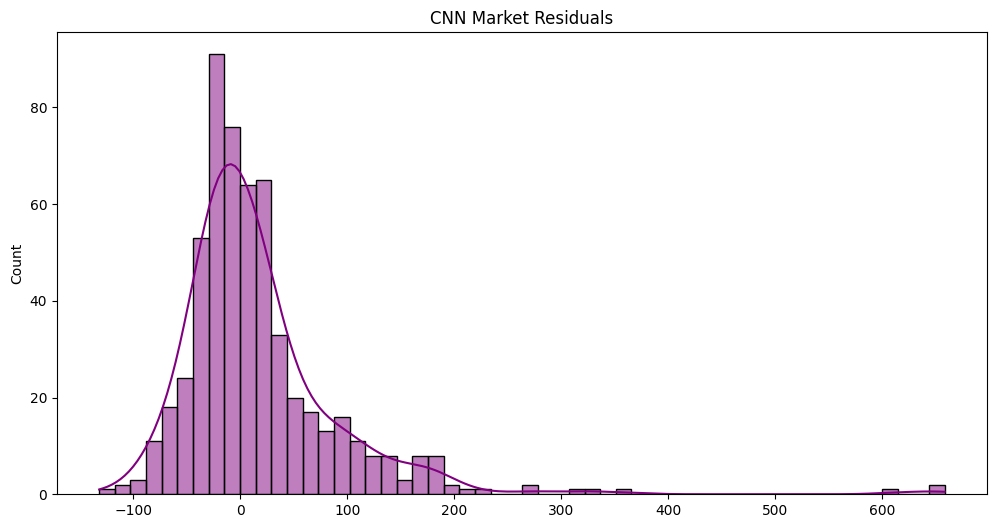

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
import pandas as pd

# In sample predictions
ffnn_macro_train_predictions = ffnn_model_macro.predict(X_train_macro)
lstm_macro_train_predictions = lstm_model_macro.predict(X_train_macro_lstm)
cnn_macro_train_predictions = cnn_model_macro.predict(X_train_macro)

ffnn_market_train_predictions = ffnn_model_market.predict(X_train_market)
lstm_market_train_predictions = lstm_model_market.predict(X_train_market_lstm)
cnn_market_train_predictions = cnn_model_market.predict(X_train_market)

# Function to evaluate and compare models
def evaluate_model_performance(model_name, y_train, y_test, train_predictions, test_predictions):
    # Calculate metrics
    in_sample_mse = mean_squared_error(y_train, train_predictions)
    out_sample_mse = mean_squared_error(y_test, test_predictions)
    in_sample_r2 = r2_score(y_train, train_predictions)
    out_sample_r2 = r2_score(y_test, test_predictions)
    
    # Calculate proportion correct and IC
    in_sample_proportion_correct = calculate_proportion_correct(train_predictions, y_train)
    out_sample_proportion_correct = calculate_proportion_correct(test_predictions, y_test)
    in_sample_ic = calculate_ic(in_sample_proportion_correct)
    out_sample_ic = calculate_ic(out_sample_proportion_correct)
    
    return {
        "Model": model_name,
        "In-sample MSE": in_sample_mse,
        "Out-sample MSE": out_sample_mse,
        "In-sample R2": in_sample_r2,
        "Out-sample R2": out_sample_r2,
        "In-sample IC": in_sample_ic,
        "Out-sample IC": out_sample_ic
    }

# Evaluate and compare all models
models_performance = []

# FFNN Macro
models_performance.append(evaluate_model_performance("FFNN Macro", y_train_macro.values, y_test_macro.values, ffnn_macro_train_predictions, ffnn_macro_predictions))

# FFNN Market
models_performance.append(evaluate_model_performance("FFNN Market", y_train_market.values, y_test_market.values, ffnn_market_train_predictions, ffnn_market_predictions))

# LSTM Macro
models_performance.append(evaluate_model_performance("LSTM Macro", y_train_macro_prepared, y_test_macro_prepared, lstm_macro_train_predictions, lstm_macro_predictions))

# LSTM Market
models_performance.append(evaluate_model_performance("LSTM Market", y_train_market_prepared, y_test_market_prepared, lstm_market_train_predictions, lstm_market_predictions))

# CNN Macro
models_performance.append(evaluate_model_performance("CNN Macro", y_train_macro.values, y_test_macro.values, cnn_macro_train_predictions, cnn_macro_predictions))

# CNN Market
models_performance.append(evaluate_model_performance("CNN Market", y_train_market.values, y_test_market.values, cnn_market_train_predictions, cnn_market_predictions))

# Convert to DataFrame for easy visualization
performance_df = pd.DataFrame(models_performance)
display(performance_df)

# Function to plot Actual vs. Predicted and Residuals
def plot_actual_vs_predicted_and_residuals(model_name, y_test, predictions):
    min_length = min(len(y_test), len(predictions))
    y_test = y_test[:min_length]
    predictions = predictions[:min_length]

    plt.figure(figsize=(12, 6))
    plt.plot(sorted(y_test), label='Actual', color='blue')
    plt.plot(sorted(predictions.flatten()), label=model_name + ' Predicted', color='red')
    plt.title(f'{model_name}: Actual vs. Predicted Prices')
    plt.legend()
    plt.show()

    residuals = y_test.flatten() - predictions.flatten()
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, color='purple')
    plt.title(f'{model_name} Residuals')
    plt.show()

# Plot for each model
for model in models_performance:
    model_name = model["Model"]
    if "Macro" in model_name:
        y_test = y_test_macro.values
        predictions = cnn_macro_predictions if model_name == "CNN Macro" else lstm_macro_predictions if model_name == "LSTM Macro" else ffnn_macro_predictions
    else:
        y_test = y_test_market.values
        predictions = cnn_market_predictions if model_name == "CNN Market" else lstm_market_predictions if model_name == "LSTM Market" else ffnn_market_predictions

    plot_actual_vs_predicted_and_residuals(model_name, y_test, predictions)


## Evaluation
Best Models: FFNN Market and CNN Market show the best overall performance.
Moderate Models: CNN Macro and FFNN Macro have moderate performance with better directional accuracy (IC).
Poor Model: LSTM Macro performs poorly with negative R² and low IC.

### Summary
Calculated Model Accuracy: We used MSE and R-squared to evaluate model performance.
Visualized Results: Plotted actual vs. predicted values for both in-sample and out-of-sample data.
Used Multiple Signal Sets: Evaluated models with macroeconomic and market/technical signals, providing economic motivation.
Analyzed Hypotheses: Formulated and tested hypotheses based on signal sets and discussed the results.
This comprehensive approach ensures we have a detailed analysis and understanding of the performance of our trading algorithm. If you need any further details or additional steps, please let me know!